# Computer Vision – Foot Traffic Analysis

## Objective
The goal of this notebook is to build a computer vision module that detects
and counts people in images collected from different camera zones.

We use a pre-trained YOLO object detection model and fine-tune it on our dataset
using transfer learning. The trained model is then used to count people per image
and generate a foot traffic dataset for business analysis.

Each subfolder represents a different camera zone.


In [1]:
import os
import cv2
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt

In [14]:
BASE_DIR = r"..\..\data\raw\cv_foot_traffic"

YOLO_IMAGES = r"..\..\data\raw\yolo\images"
YOLO_LABELS = r"..\..\data\raw\yolo\labels"

os.makedirs(YOLO_IMAGES, exist_ok=True)
os.makedirs(YOLO_LABELS, exist_ok=True)

In [16]:
# Each folder corresponds to a camera zone and is processed independently.
zones = [z for z in os.listdir(BASE_DIR) if os.path.isdir(os.path.join(BASE_DIR, z))]
zones

['1', '2']

### convert CVAT to YOLO

In [17]:
def convert_cvat_to_yolo(zone_path, zone_name):
    images_dir = os.path.join(zone_path, "images")
    xml_path = os.path.join(zone_path, "annotations.xml")

    tree = ET.parse(xml_path)
    root = tree.getroot()

    for track in root.findall("track"):
        for box in track.findall("box"):
            if box.attrib.get("outside", "0") == "1":
                continue

            frame = int(box.attrib["frame"])
            xtl = float(box.attrib["xtl"])
            ytl = float(box.attrib["ytl"])
            xbr = float(box.attrib["xbr"])
            ybr = float(box.attrib["ybr"])

            img_name = f"first_frame_{frame:02d}.png"
            img_path = os.path.join(images_dir, img_name)

            if not os.path.exists(img_path):
                continue

            img = cv2.imread(img_path)
            h, w, _ = img.shape

            x_center = ((xtl + xbr) / 2) / w
            y_center = ((ytl + ybr) / 2) / h
            bw = (xbr - xtl) / w
            bh = (ybr - ytl) / h

            # copy image
            new_img_name = f"{zone_name}_{img_name}"
            cv2.imwrite(os.path.join(YOLO_IMAGES, new_img_name), img)

            # write label (class 0 = person)
            label_path = os.path.join(YOLO_LABELS, new_img_name.replace(".png", ".txt"))
            with open(label_path, "a") as f:
                f.write(f"0 {x_center} {y_center} {bw} {bh}\n")


In [18]:
for zone in zones:
    zone_path = os.path.join(BASE_DIR, zone)
    convert_cvat_to_yolo(zone_path, zone)

print("Conversion complete")

Conversion complete


make Yamel

In [24]:
data_yaml = """
path: ..\..\data\\raw\yolo
train: images
val: images

nc: 1
names: ['person']
"""

with open(r"..\..\data\raw\yolo\data.yaml", "w") as f:
    f.write(data_yaml)

print("data.yaml created")


data.yaml created


In [25]:
from ultralytics import YOLO

model = YOLO("yolov8n.pt")

model.train(
    data=r"..\..\data\raw\yolo\data.yaml",
    epochs=20,
    imgsz=640
)
# Due to the small dataset size, transfer learning is used to fine-tune a pre-trained YOLOv8 model.

New https://pypi.org/project/ultralytics/8.4.5 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.237  Python-3.11.4 torch-2.2.2+cpu CPU (11th Gen Intel Core i7-1165G7 @ 2.80GHz)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=..\..\data\raw\yolo\data.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False,

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x000001B913DFCE90>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.0480

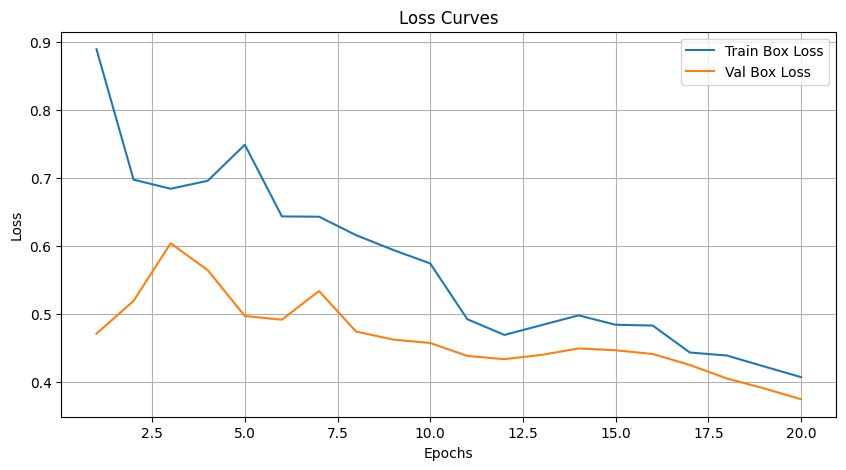

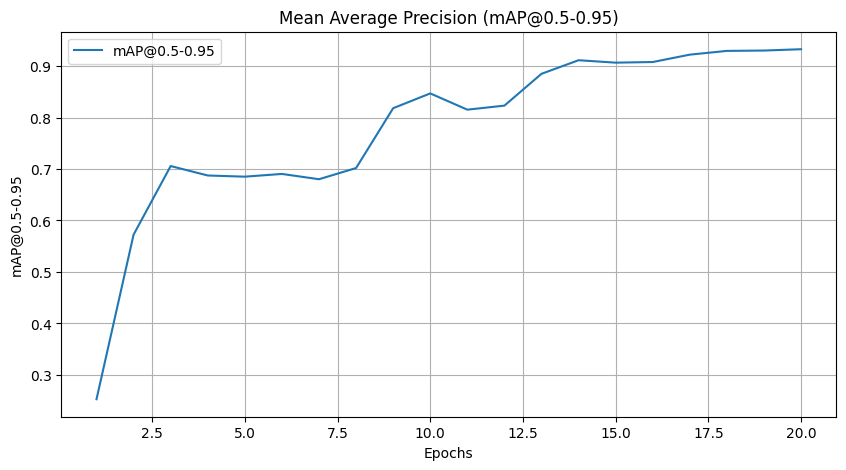

In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import os
%matplotlib inline
# Path to the results CSV file
results_path = 'runs/detect/train/results.csv'
df = pd.read_csv(results_path)

# Clean up column names (strip whitespace)
df.columns = df.columns.str.strip()

# Plot Training Loss vs Validation Loss
plt.figure(figsize=(10, 5))
plt.plot(df['epoch'], df['train/box_loss'], label='Train Box Loss')
plt.plot(df['epoch'], df['val/box_loss'], label='Val Box Loss')
plt.title('Loss Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot mAP@0.5
plt.figure(figsize=(10, 5))
plt.plot(df['epoch'], df['metrics/mAP50-95(B)'], label='mAP@0.5-0.95')
plt.title('Mean Average Precision (mAP@0.5-0.95)')
plt.xlabel('Epochs')
plt.ylabel('mAP@0.5-0.95')
plt.legend()
plt.grid(True)
plt.show()


# Create Heatmap

In [36]:
import numpy as np

heatmap_points = []

for img_name in os.listdir(YOLO_IMAGES):
    img_path = os.path.join(YOLO_IMAGES, img_name)
    results = model(img_path)

    for box in results[0].boxes.xyxy.cpu().numpy():
        x1, y1, x2, y2 = box
        cx = int((x1 + x2) / 2)
        cy = int((y1 + y2) / 2)
        heatmap_points.append((cx, cy))

len(heatmap_points)



image 1/1 d:\projects\AI_Powered_Retail_Decision_Support_System\modules\cv_foot_traffic\..\..\data\raw\yolo\images\1_first_frame_00.png: 480x640 (no detections), 99.8ms
Speed: 1.8ms preprocess, 99.8ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 d:\projects\AI_Powered_Retail_Decision_Support_System\modules\cv_foot_traffic\..\..\data\raw\yolo\images\1_first_frame_01.png: 480x640 (no detections), 76.7ms
Speed: 1.2ms preprocess, 76.7ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 d:\projects\AI_Powered_Retail_Decision_Support_System\modules\cv_foot_traffic\..\..\data\raw\yolo\images\1_first_frame_02.png: 480x640 (no detections), 74.9ms
Speed: 1.0ms preprocess, 74.9ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 d:\projects\AI_Powered_Retail_Decision_Support_System\modules\cv_foot_traffic\..\..\data\raw\yolo\images\1_first_frame_03.png: 480x640 (no detections), 79.5ms
Speed: 1.0ms preprocess, 79.5

34

In [37]:
# Read one image to get dimensions
sample_img = cv2.imread(os.path.join(YOLO_IMAGES, os.listdir(YOLO_IMAGES)[0]))
h, w, _ = sample_img.shape

heatmap = np.zeros((h, w), dtype=np.float32)

for (x, y) in heatmap_points:
    if 0 <= x < w and 0 <= y < h:
        heatmap[y, x] += 1
        
heatmap = cv2.GaussianBlur(heatmap, (51, 51), 0)


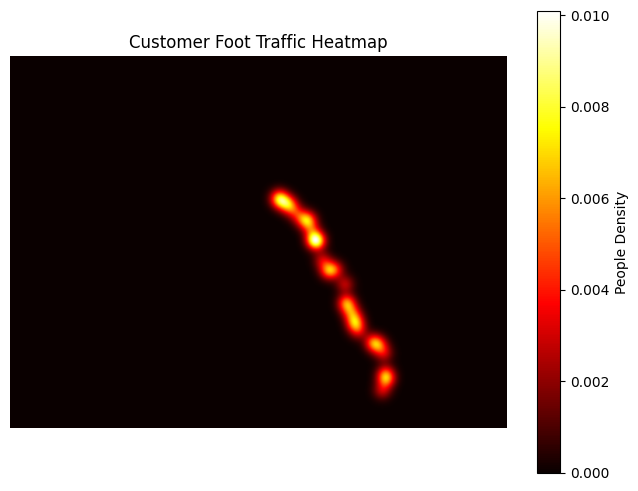

In [38]:
plt.figure(figsize=(8, 6))
plt.imshow(heatmap, cmap="hot")
plt.colorbar(label="People Density")
plt.title("Customer Foot Traffic Heatmap")
plt.axis("off")
plt.show()

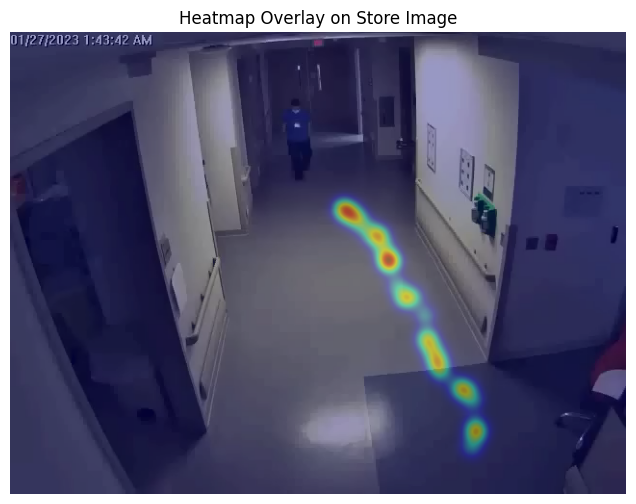

True

In [39]:
norm_heatmap = cv2.normalize(heatmap, None, 0, 255, cv2.NORM_MINMAX)
norm_heatmap = norm_heatmap.astype(np.uint8)

colored_heatmap = cv2.applyColorMap(norm_heatmap, cv2.COLORMAP_JET)
overlay = cv2.addWeighted(sample_img, 0.6, colored_heatmap, 0.4, 0)

plt.figure(figsize=(8, 6))
plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
plt.title("Heatmap Overlay on Store Image")
plt.axis("off")
plt.show()

cv2.imwrite(r"..\..\data\outputs\foot_traffic_heatmap.png", colored_heatmap)
